# Training Plots

In [1]:
# importing necessary libraries and the cnn architecture I defined

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
import copy
import pandas as pd
import seaborn as sns

2024-07-23 18:09:18.274305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis_no_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train Loop

In [2]:
# modified train loop to also work with sparse networks (such that pruned weights remain frozen at 0.0)

def train_loop_sparse(train, test, model, num_epochs=5):
    
    # hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializing training statistics
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for epoch in tqdm(range(num_epochs), leave=False, desc="training epochs"):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # set gradients to zero for all pruned weights
            new_gradients = []
            for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                gradient_matrix = tf.where(variables == 0.0, 0.0, gradient_matrix)
                new_gradients.append(gradient_matrix)
            optimizer.apply_gradients(zip(new_gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        # updataing training statistics
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()
        
    # collecting losses in a dictionary
    losses = {"test loss":test_l , "training loss":train_l , "test accuracy":test_acc , "training accuracy":train_acc}
    losses = pd.DataFrame.from_dict(losses, orient='columns')
    
    return  losses

## Training and extracting Training Statistics
on
- Winning Tickets
- Random Tickets
- Control Models

In [3]:
def train_control(train_dataset, test_dataset, nr):

    all_losses = pd.DataFrame()

    for i in range(nr):

        control_model = CNN2Model()
        control_losses = train_loop_sparse(train_dataset, test_dataset, control_model)
        control_losses["model_nr"] = i
        control_losses["Sparsity"] = "original"
        control_losses["epochs"] = control_losses.index

        all_losses = pd.concat([all_losses, control_losses], axis=0)
    
    return all_losses
    


In [4]:
def train_wts(train_dataset, test_dataset, dataset, nrs):

    all_losses = pd.DataFrame()

    for i in nrs:

        wt_model = CNN2Model()
        wt_model(list(train_dataset)[0][0])
        wt_model.load_weights(f"1b WTs/h5_format/WT_{dataset}_IMP_{i}.h5")


        wt_losses = train_loop_sparse(train_dataset, test_dataset, wt_model)
        wt_losses["model_nr"] = i
        wt_losses["Sparsity"] = "WT"
        wt_losses["epochs"] = wt_losses.index

        all_losses = pd.concat([all_losses, wt_losses], axis=0)
    
    return all_losses

In [5]:
def train_random_sparse(train_dataset, test_dataset, nrs):

    all_losses = pd.DataFrame()

    for i in nrs:

        random_sparse_model = CNN2Model()
        random_sparse_model(list(train_dataset)[0][0])
        random_sparse_model.load_weights(f"1b WTs/h5_format/RSN_{i}.h5")


        random_sparse_losses = train_loop_sparse(train_dataset, test_dataset, random_sparse_model)
        random_sparse_losses["model_nr"] = i
        random_sparse_losses["Sparsity"] = "RSN"
        random_sparse_losses["epochs"] = random_sparse_losses.index

        all_losses = pd.concat([all_losses, random_sparse_losses], axis=0)
    
    return all_losses

In [6]:
def get_train_statistics(dataset):
    
    nr = 15

    train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=60, shuffle_size=512)

    control_stats = train_control(train_dataset, test_dataset, nr)
    control_stats["dataset"]=dataset
    #display(control_stats)
    control_stats.to_csv(f'6b Training statistics/{dataset}_original_training_stats.csv', index=False)

    wts_stats = train_wts(train_dataset, test_dataset, dataset, range(nr))
    wts_stats["dataset"]=dataset
    #display(wts_stats)
    wts_stats.to_csv(f'6b Training statistics/{dataset}_WT({dataset})_training_stats.csv', index=False)

    random_stats = train_random_sparse(train_dataset, test_dataset, range(nr))
    random_stats["dataset"]=dataset
    #display(random_stats)
    random_stats.to_csv(f'6b Training statistics/{dataset}_RSN_training_stats.csv', index=False)

    coll_stats = pd.concat([control_stats,wts_stats,random_stats], axis =0)
    coll_stats.to_csv(f'6b Training statistics/{dataset}_collective_training_stats.csv', index=False)

In [7]:
# get_train_statistics("CIFAR")
# get_train_statistics("CINIC")
# get_train_statistics("SVHN")

In [8]:
def get_train_statistics_cross_wts(dataset):
    
    nr = 15

    train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=60, shuffle_size=512)

    control_stats = pd.read_csv(f'6b Training statistics/{dataset}_original_training_stats.csv')
    random_stats = pd.read_csv(f'6b Training statistics/{dataset}_RSN_training_stats.csv')
    wts_stats = pd.read_csv(f'6b Training statistics/{dataset}_WT({dataset})_training_stats.csv')
    wts_stats["Sparsity"] = f"WT({dataset})"

    coll_stats = pd.concat([control_stats,wts_stats,random_stats], axis=0)

    for other_dataset in ["CIFAR","CINIC","SVHN"]:
        if dataset != other_dataset:

            wts_stats = train_wts(train_dataset, test_dataset, other_dataset, range(nr))
            wts_stats["dataset"]=dataset
            wts_stats["Sparsity"] = f"WT({other_dataset})"
            wts_stats.to_csv(f'6b Training statistics/{dataset}_WT({other_dataset})_training_stats.csv', index=False)

            coll_stats = pd.concat([coll_stats,wts_stats], axis =0)

    coll_stats.to_csv(f'6b Training statistics/{dataset}_collective_training_stats.csv', index=False)

In [9]:
# get_train_statistics_cross_wts("CIFAR")
# get_train_statistics_cross_wts("CINIC")
# get_train_statistics_cross_wts("SVHN")

## Plotting the training statistics

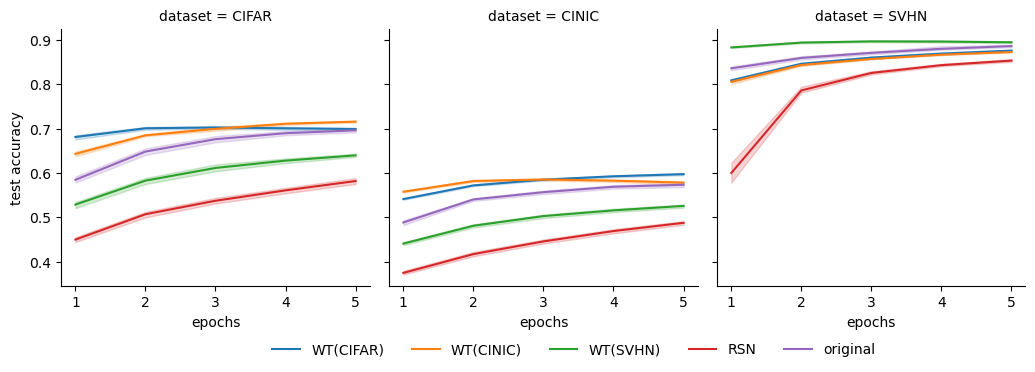

In [14]:
#fig, axes = plt.subplots(1, 3, figsize=(10,3), constrained_layout=True, sharex=True, sharey=True,)

all_train_stats = pd.DataFrame()

for i, dataset in enumerate(["CIFAR","CINIC","SVHN"]):

    # extract collective sign distribution
    train_stats = pd.read_csv(f'6b Training statistics/{dataset}_collective_training_stats.csv')
    train_stats = train_stats[["test accuracy","epochs","Sparsity","model_nr","dataset"]]
    all_train_stats = pd.concat([all_train_stats,train_stats], axis=0)

all_train_stats["epochs"] = all_train_stats["epochs"] + 1

plot = sns.relplot(data=all_train_stats, x="epochs", y="test accuracy", hue="Sparsity", hue_order=["WT(CIFAR)","WT(CINIC)","WT(SVHN)","RSN","original"], 
                    errorbar=('ci', 100), col="dataset", kind="line", height=3.5)

sns.move_legend(
    plot, "lower center",
    bbox_to_anchor=(.5, -0.07), ncol=5, title=None, frameon=False,
)
plot.savefig(f"6b Training statistics/training_stats_all_datasets_and_wts.png")
    